# hw6

I'll be doing *Stellar Populations, Numerics Exercise #1*.

> There is a Python interface to the Flexible Stellar Population Synthesis (FSPS; Conroy et al. 2009) software, which is one of several libraries that exist for this purpose. Install this package and (using the scant available documentation!) run it to produce spectra for dustfree populations with a range of ages and metallicities. Specifically, do 25 models, with five metallicities and five ages spaced logarithmically between $Z/Z_\odot = 0.01$ and $Z/Z_\odot = 2$, and age = $10^8$ years and age = $10^{10}$ years. Then create the same set of models with a modest amount of dust reddening (say around $A_V \sim 0.5$). Plot the spectra for comparison with each other in the UV through near-IR range. Warning: this software is incredibly slow.

In [1]:
%env SPS_HOME=/Users/connor/Documents/nyu/2024-25F/exgal/hw6/fsps/
import fsps
import numpy as np
import matplotlib.pyplot as plt
import chic
from tqdm.auto import tqdm

env: SPS_HOME=/Users/connor/Documents/nyu/2024-25F/exgal/hw6/fsps/


In [2]:
# initialize our one stellarpop object
sp = fsps.StellarPopulation(
    compute_vega_mags=False, zcontinuous=1,
    sfh=0, logzsol=0.0, dust_type=1
)

In [3]:
Zs = np.geomspace(0.01, 2, num=5)
ages = np.geomspace(1e8, 1e10, num=5)

print('metallicities:', Zs)
print('ages:', ages)

metallicities: [0.01       0.03760603 0.14142136 0.53182959 2.        ]
ages: [1.00000000e+08 3.16227766e+08 1.00000000e+09 3.16227766e+09
 1.00000000e+10]


First, we compute our dust-free spectra.

In [4]:
# dustfree
dustfree_spectra = dict()

for Z in Zs:
    sp.params['logzsol'] = np.log10(Z)
    dustfree_spectra[Z] = dict()

    for age in tqdm(ages):
        wave, spec = sp.get_spectrum(tage=age / 1e9)
        dustfree_spectra[Z][age] = (wave, spec)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Next, we'll try to compute our dusty spectra. The `'dusttype'` parameter was set to `1`, which corresponds to the Cardelli-Clayton-Mathis 1989 extinction model. The parameter of interest for this model is $R = A_V / E(B-V)$. I don't know what $E(B-V)$ is, but we want to set $A_V \sim 0.5$, so I chose $R = 0.5$. (This is probably not right.)

Then, the strength of dust attenuation from this model is set by `'dust2'`. Again, I don't know what exactly this parameter describes (I know it controls the 'strength' of the attenuation, but is it unitful? is it a fraction out of 1?), so I just chose 1.0 to see if there was an effect.

In [54]:
# dusty
sp.params['dust2'] = 1.0
sp.params['mwr'] = 0.5

dusty_spectra = dict()

for Z in Zs:
    sp.params['logzsol'] = np.log10(Z)
    dusty_spectra[Z] = dict()

    for age in tqdm(ages):
        wave, spec = sp.get_spectrum(tage=age / 1e9)
        dusty_spectra[Z][age] = (wave, spec)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Now we can plot our spectra.

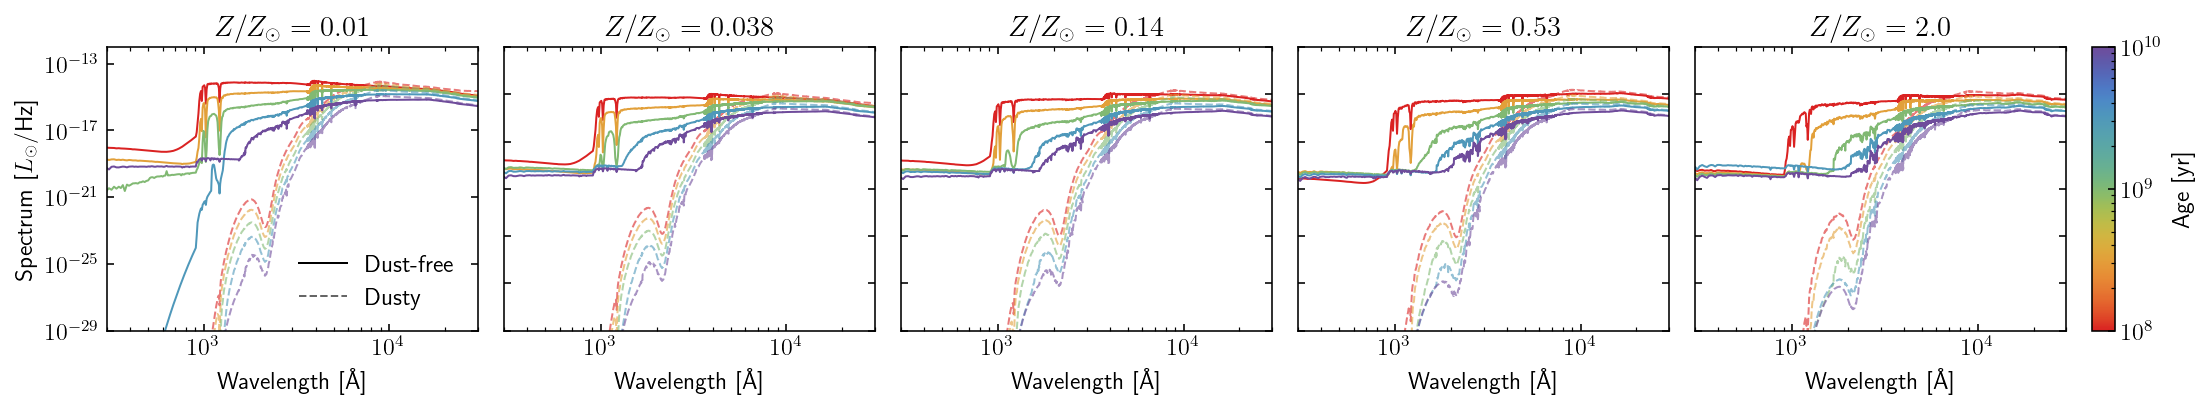

In [55]:
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D

fig, axs = plt.subplots(1, len(Zs) + 1, figsize=(3 * len(Zs) + 0.5, 3), gridspec_kw=dict(width_ratios=[8] * len(Zs) + [0.5]))
cax = axs[-1]
axs = axs[:-1]

cmap = plt.get_cmap('tol_rainbow_PuRd_r')
norm = LogNorm(vmin=ages.min(), vmax=ages.max())

for i, Z in enumerate(Zs):
    for age in ages:
        wave, spec = dustfree_spectra[Z][age]
        axs[i].plot(wave, spec, color=cmap(norm(age)), lw=1)

        wave, spec = dusty_spectra[Z][age]
        axs[i].plot(wave, spec, color=cmap(norm(age)), lw=1, ls='--', alpha=0.6)
    axs[i].set_title(f'$Z/Z_\\odot = {Z:.2}$')

for ax in axs.flat:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-29, 1e-12)
    ax.set_xlim(3e2, 3e4)
    ax.set_xlabel('Wavelength [Å]')

for ax in axs[1:]:
    ax.set_yticks(axs[0].get_yticks()[1:-1])
    ax.set_yticklabels([])

axs[0].set_ylabel('Spectrum [$L_\\odot$/Hz]')
axs[0].legend([
    Line2D([0], [0], color='black', lw=1, ls='-'),
    Line2D([0], [0], color='black', alpha=0.6, lw=1, ls='--'),
], ['Dust-free', 'Dusty'], frameon=False)

cb = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='Age [yr]')

fig.tight_layout()
plt.show()

The dust imparts a characteristic shape on all spectra. It severely suppresses the spectrum at lower wavelengths, while leaving the highest wavelengths largely unchanged (in our wavelength range of interest).